In [1]:
# imports
import pandas as pd
import numpy as np
import time

# seed
np.random.seed(0)

In [2]:
# where data is located
!ls ./drive/MyDrive/Thesis\ Workspace/Notebooks/data/set-2
DATA_PATH = "./drive/MyDrive/Thesis Workspace/Notebooks/data/set-2"

tweets	users


In [3]:
# load user data
df_user_bot = pd.concat(
    [
        pd.read_csv(f'{DATA_PATH}/users/social_spambots_1.csv'),
        pd.read_csv(f'{DATA_PATH}/users/social_spambots_2.csv'),
        pd.read_csv(f'{DATA_PATH}/users/social_spambots_3.csv')
    ]
).reset_index(drop=True)

df_user_naive = pd.read_csv(f'{DATA_PATH}/users/geniune_accounts.csv')
print('Shapes', df_user_bot.shape, df_user_naive.shape)


Shapes (4912, 42) (3474, 42)


### Note:
**Precounted tweets data file size**
- bot1: 1610034 rows
- bot2: 428542 rows
- bot3: 1418557 rows
- naive: 8377522 rows

### TODO:
**Reads random rows from data rather than first rows**

=> Method: could read df and than sample down and save as a small csv

In [4]:
df_tweet_bot = pd.concat(
    [
        pd.read_csv(f'{DATA_PATH}/tweets/social_spambots_1.csv'),
        pd.read_csv(f'{DATA_PATH}/tweets/social_spambots_2.csv'),
        pd.read_csv(f'{DATA_PATH}/tweets/social_spambots_3.csv')
    ]
).reset_index(drop=True)

df_tweet_naive = pd.read_csv(f'{DATA_PATH}/tweets/tweets.csv', header=None, escapechar='\\')
df_tweet_naive.drop(12, axis=1, inplace=True)
df_tweet_naive.columns = df_tweet_bot.columns
print('Shapes', df_tweet_bot.shape, df_tweet_naive.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shapes (3457133, 25) (8377522, 25)


### Features
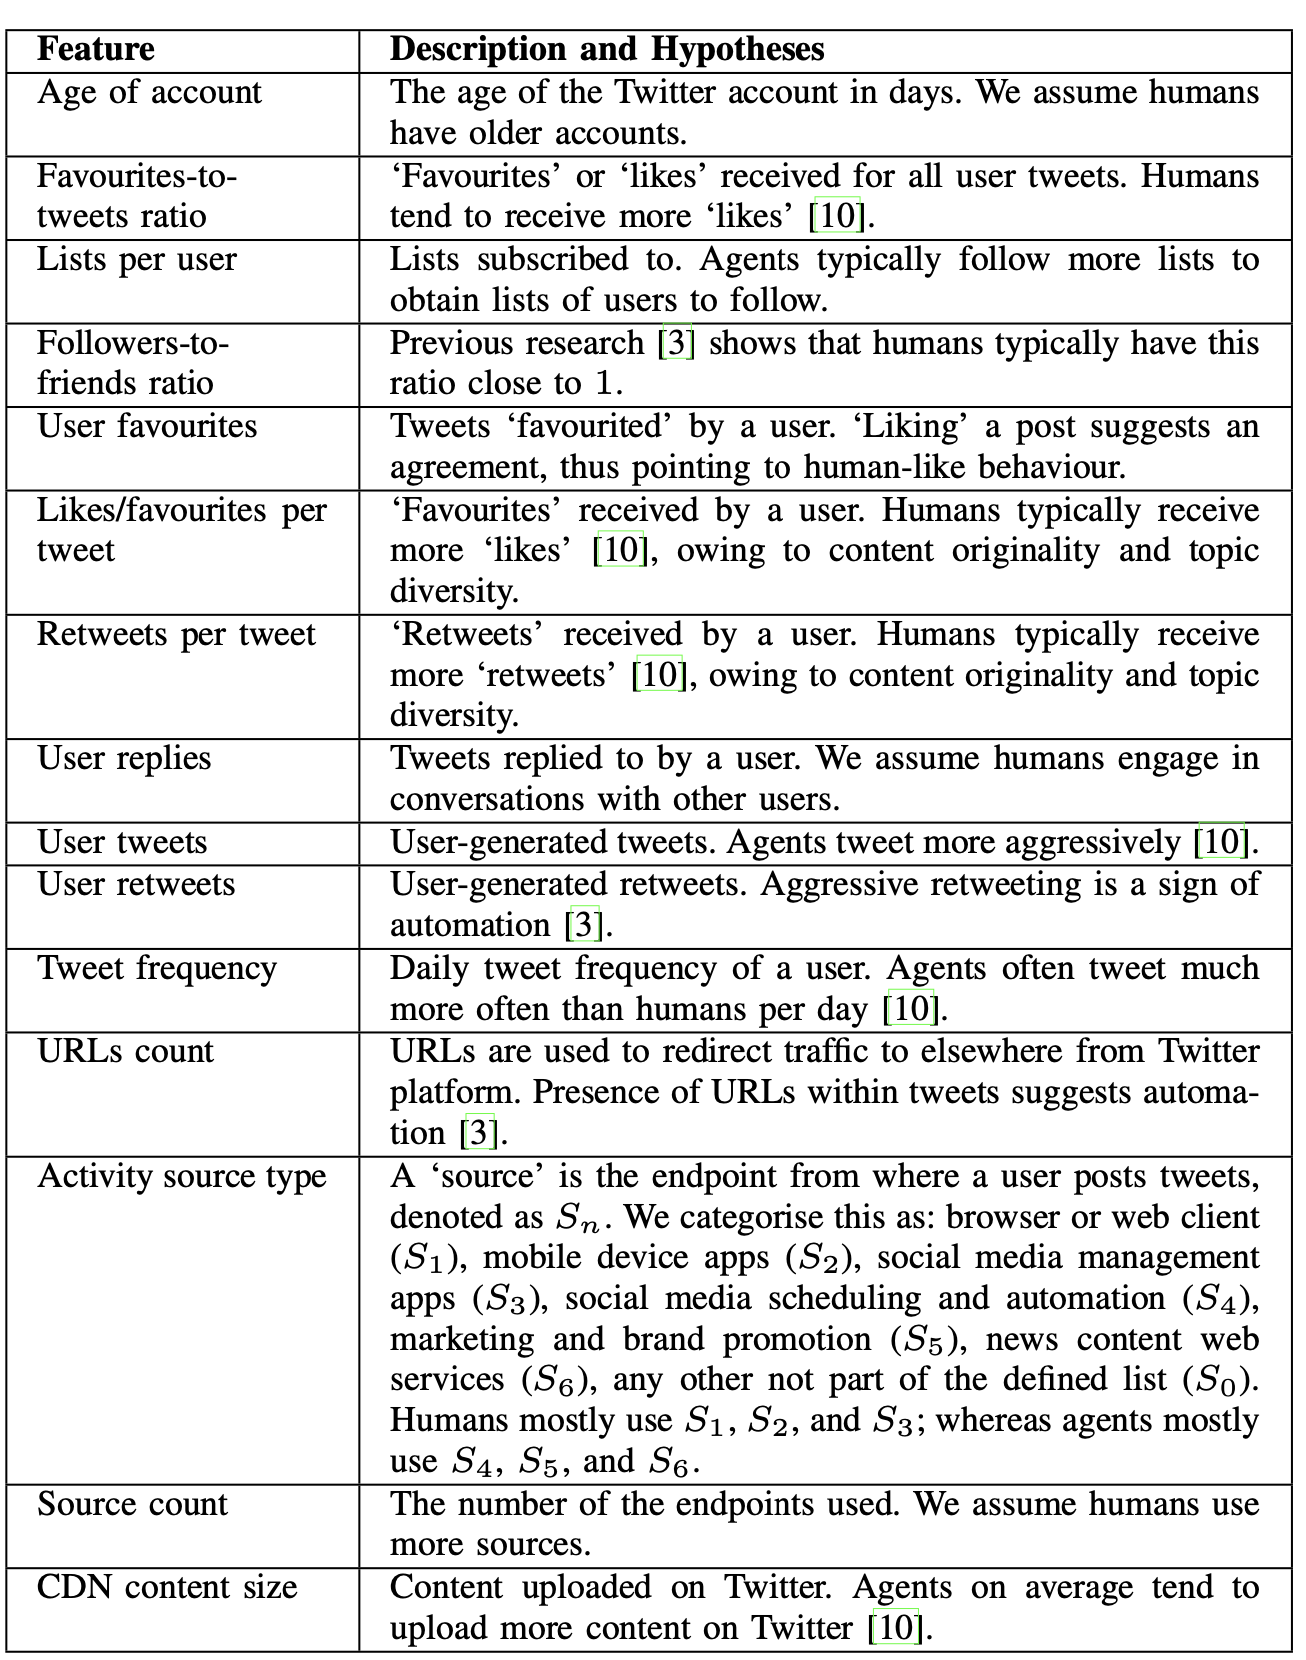

## NOTE
- Cant implement on set1 data since no tweet data
- Paper summarized info can be found here [Link](https://exclusive-cream-7e9.notion.site/33-Random-Forest-c7256b197e6a44319e1231da84403708)

# Processing


### From user_data
- tweet count
- user favorite
- list count
- age (day)
- follower/friend ratio
- tweet_freq (day)

In [5]:
def process_user_data(df):
  used_columns = [
        'statuses_count',
        'favourites_count',
        'listed_count',
    ]

  df_return = df[used_columns]
  age = (pd.to_datetime(df['updated']) - pd.to_datetime(df['created_at']).dt.tz_localize(None)) / np.timedelta64(1, 'Y')
  df_return['age'] = age
  df_return['follower_to_friend_ratio'] = df['followers_count']/df['friends_count']
  df_return['tweet_frequency'] = df['statuses_count']/age #check, perday or what?
  df_return['user_id'] = df['id']
  return df_return

feature_time = time.time()
df_user_bot_new, df_user_naive_new = [process_user_data(df) for df in [df_user_bot, df_user_naive]]
end_feature_time = time.time()
print('Time: ', end_feature_time - feature_time)
print('Shapes: ', df_user_bot_new.shape, df_user_naive_new.shape)
df_user_bot_new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Time:  1.5648674964904785
Shapes:  (4912, 7) (3474, 7)


,statuses_count,favourites_count,listed_count,age,follower_to_friend_ratio,tweet_frequency,user_id
0,1299,1,0,6.995963,0.550000,185.678511,24858289
1,18665,16358,110,6.904962,3.649332,2703.128629,33212890
2,22987,14,6,6.839143,0.794702,3361.093391,39773427
3,7975,11,2,6.666963,1.137143,1196.196831,57007623
4,20218,162,8,6.608517,1.019753,3059.385303,63258466


### From tweet_data
- total favorites received to all tweets
- Like per tweet
- Retweet per tweet
- total retweet
- url count
- activity source type: actually number of different sources an account use in total
- **cdn content size: THIS IS THE UPLOADED MEDIA SIZE, we do not have this information!**

In [6]:
def process_tweet_data(df):
  df_grouped = df.groupby('user_id')
  df_return = pd.DataFrame()
  tweet_count = df_grouped['user_id'].count()
  favorite_received = df_grouped['favorite_count'].sum()
  df_return['favorite_received'] = favorite_received
  df_return['favorite_received_ratio'] = favorite_received / tweet_count

  retweet_received = df_grouped['retweet_count'].sum()
  df_return['retweet_received'] = retweet_received
  df_return['retweet_received_ratio'] = retweet_received / tweet_count
  
  df_return['url_count'] = df_grouped['num_urls'].sum()
  df_return['activity_source_count'] = df_grouped['source'].nunique()
  return df_return

feature_time = time.time()
df_tweet_bot_new, df_tweet_naive_new = [process_tweet_data(df) for df in [df_tweet_bot, df_tweet_naive]]
end_feature_time = time.time()
print('Time: ', end_feature_time - feature_time)
print('shapes: ', df_tweet_bot_new.shape, df_tweet_naive_new.shape)
df_tweet_bot_new.head()

Time:  3.1332144737243652
shapes:  (4912, 6) (3394, 6)


,favorite_received,favorite_received_ratio,retweet_received,retweet_received_ratio,url_count,activity_source_count
user_id,,,,,,
16195340,437,0.134793,632,0.194941,2331,12
16282004,23,0.007141,28,0.008693,2796,5
16740486,84,0.138843,292120,482.842975,208,13
17132768,1872,0.580465,7769,2.408992,124,12
18013384,125,0.038616,5049,1.559778,1600,7


### Merge

In [7]:
df_bot = pd.merge(df_user_bot_new, df_tweet_bot_new, on='user_id')
df_naive = pd.merge(df_user_naive_new, df_tweet_naive_new, on='user_id')
print(df_bot.shape,df_naive.shape)

(4912, 13) (3394, 13)


### Check and cleanup

In [8]:
df_bot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4912 entries, 0 to 4911
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   statuses_count            4912 non-null   int64  
 1   favourites_count          4912 non-null   int64  
 2   listed_count              4912 non-null   int64  
 3   age                       4912 non-null   float64
 4   follower_to_friend_ratio  4607 non-null   float64
 5   tweet_frequency           4912 non-null   float64
 6   user_id                   4912 non-null   int64  
 7   favorite_received         4912 non-null   int64  
 8   favorite_received_ratio   4912 non-null   float64
 9   retweet_received          4912 non-null   int64  
 10  retweet_received_ratio    4912 non-null   float64
 11  url_count                 4912 non-null   int64  
 12  activity_source_count     4912 non-null   int64  
dtypes: float64(5), int64(8)
memory usage: 537.2 KB


In [9]:
df_bot.apply(lambda x: x.unique())


statuses_count              [1299, 18665, 22987, 7975, 20218, 15259, 9551,...
favourites_count            [1, 16358, 14, 11, 162, 55, 655, 38, 0, 3, 874...
listed_count                [0, 110, 6, 2, 8, 1, 28, 3, 5, 7, 11, 9, 66, 8...
age                         [6.995963044846663, 6.9049618290131445, 6.8391...
follower_to_friend_ratio    [0.55, 3.6493317838466006, 0.7947019867549668,...
tweet_frequency             [185.67851083159508, 2703.1286286875243, 3361....
user_id                     [24858289, 33212890, 39773427, 57007623, 63258...
favorite_received           [8, 31586, 109, 46, 834, 12, 413, 50, 926, 882...
favorite_received_ratio     [0.003177124702144559, 9.858302122347066, 0.03...
retweet_received            [11, 37519, 477172, 171137, 100333, 92, 643251...
retweet_received_ratio      [0.004368546465448769, 11.710049937578027, 148...
url_count                   [2038, 1073, 2025, 479, 423, 2852, 320, 43, 33...
activity_source_count       [34, 4, 12, 8, 14, 11, 6, 1, 2, 3, 9

In [10]:
df_bot.isin([np.nan, np.inf, -np.inf]).sum()

statuses_count                0
favourites_count              0
listed_count                  0
age                           0
follower_to_friend_ratio    391
tweet_frequency               0
user_id                       0
favorite_received             0
favorite_received_ratio       0
retweet_received              0
retweet_received_ratio        0
url_count                     0
activity_source_count         0
dtype: int64

In [11]:
df_naive.isin([np.nan, np.inf, -np.inf]).sum()

statuses_count              0
favourites_count            0
listed_count                0
age                         0
follower_to_friend_ratio    1
tweet_frequency             0
user_id                     0
favorite_received           0
favorite_received_ratio     0
retweet_received            0
retweet_received_ratio      0
url_count                   0
activity_source_count       0
dtype: int64

In [12]:
df_bot = df_bot.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
df_naive = df_naive.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Save to csv for use

In [13]:
save_path = "./drive/MyDrive/Thesis Workspace/Notebooks/data/sb14-set2/"
df_naive.to_csv(save_path + 'naive.csv', index = False)
df_bot.to_csv(save_path + 'bot.csv', index = False)